https://github.com/pragyasingh7/Concrete-AutoEncoder-Pytorch

In [13]:
import math
import os

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

from graphFeatureSelect.utils import *
from graphFeatureSelect.dataset import MNIST, Superconductivity
from graphFeatureSelect.concrete_autoencoder import ConcreteAutoEncoder


# ----------------------------------------------------------
# Constants
# ----------------------------------------------------------
DATASET = 'mnist'
MISSING_DATA = False
DATA_IMPUTATION = 'mean'
BATCH_ADJUST = False
SUFFIX = ""
NUM_TRYOUTS = 4
START_TEMP = 10.0
MIN_TEMP = 0.01
MEAN_MAX_TARGET = 0.998
BATCH_SIZE = 64
DECODER_TYPE = 'lr'
LEARNING_RATE = 1e-3

k = 20
num_epochs = 100

IS_SPARSE = True if MISSING_DATA and DATA_IMPUTATION is None else False




In [14]:
# ----------------------------------------------------------
# Load Dataset
# ----------------------------------------------------------
if DATASET == 'mnist':
    input_dim = 28*28
    trainset = MNIST(train=True, missing_data=MISSING_DATA)
    testset = MNIST(train=False, missing_data=MISSING_DATA)
elif DATASET == 'super':
    input_dim = 81
    trainset = Superconductivity(train=True, missing_data=MISSING_DATA)
    testset = Superconductivity(train=False, missing_data=MISSING_DATA)
else:
    raise ValueError(f'Unsupported dataset {DATASET}')

indices = list(range(len(trainset)))
n_train_samples = int(0.8 * len(trainset))
np.random.shuffle(indices)
train_idx, val_idx = indices[:n_train_samples], indices[n_train_samples:]
train_sampler, val_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(val_idx)

train_dataloader = DataLoader(trainset, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(trainset, sampler=val_sampler, batch_size=len(val_idx))

masked_mean = None
if MISSING_DATA and DATA_IMPUTATION == 'mean':
    masked_mean = train_masked_mean(trainset, train_idx)

X_test, X_mask_test = testset.data, testset.data_mask


In [15]:
# ----------------------------------------------------------
# Run training and eval
# ----------------------------------------------------------
# for i in range(NUM_TRYOUTS):
alpha = math.exp(math.log(MIN_TEMP / START_TEMP) / (num_epochs * len(train_dataloader)))

model = ConcreteAutoEncoder(input_dim, k, start_temp=START_TEMP, min_temp=MIN_TEMP, alpha=alpha,
                            decoder_type=DECODER_TYPE)
                            
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_criterion = torch.nn.MSELoss(reduction='none' if BATCH_ADJUST else 'sum')
eval_criterion = torch.nn.MSELoss(reduction='sum')
losses = {'train': [], 'complete_val': [], 'sparse_val': []}
annealing_schedule = {'temp': [], 'complete val loss': [], 'mean-max alpha': []}

for j in range(num_epochs):
    epoch_loss = 0
    for X, _ in train_dataloader:
        optimizer.zero_grad()

        if IS_SPARSE:
            X, X_mask = X[0], X[1]
            loss_multiplier = 1 / torch.sum(X_mask)
        elif MISSING_DATA and DATA_IMPUTATION == 'mean':
            X, X_mask = impute_mean(X[0], X[1], masked_mean), None
            loss_multiplier = 1 / torch.numel(X)
        else:
            X, X_mask = X, None
            loss_multiplier = 1 / torch.numel(X)

        output = model(X, X_mask=X_mask)

        if BATCH_ADJUST:
            r = torch.div(BATCH_SIZE, torch.sum(X_mask, dim=0) + 1e-7)
            loss = torch.sum(r * train_criterion(output, X)) * loss_multiplier
            # r = torch.div(1, torch.sum(X_mask, dim=0) + 1e-7)
            # loss = torch.sum(r * train_criterion(output, X))
        else:
            loss = train_criterion(output, X) * loss_multiplier

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    losses['train'].append(epoch_loss)
    print(f'For Epoch {j}, Loss: {epoch_loss}')

    # --- Calculate val losses ---
    model.eval()

    for X, _ in val_dataloader:
        if IS_SPARSE:
            X, X_mask = X[0], X[1]
            val_output = model(X, train=False, X_mask=X_mask)
        elif MISSING_DATA and DATA_IMPUTATION == 'mean':
            X, X_mask = X[0], X[1]
            X_ = impute_mean(X, X_mask, masked_mean)
            val_output = model(X_, train=False, X_mask=None)
        else:
            X, X_mask = X, None
            val_output = model(X, train=False, X_mask=None)

        loss_multiplier = 1 / torch.numel(X)
        complete_val_loss = eval_criterion(val_output, X) * loss_multiplier
        print(f'Complete val loss for epoch {j}: {complete_val_loss}')
        losses['complete_val'].append(complete_val_loss.item())

        annealing_schedule['complete val loss'].append(complete_val_loss.item())
        annealing_schedule['temp'].append(model.encoder.temp)
        annealing_schedule['mean-max alpha'].append(model.get_mean_max().detach().numpy())

        if MISSING_DATA:
            loss_multiplier = 1 / torch.sum(X_mask)
            sparse_val_loss = eval_criterion(val_output * X_mask, X * X_mask) * loss_multiplier
            print(f'Sparse val loss for epoch {j}: {sparse_val_loss}')
            losses['sparse_val'].append(sparse_val_loss.item())

    model.train()



For Epoch 0, Loss: 0.06816544608275095
Complete val loss for epoch 0: 0.21499614417552948
For Epoch 1, Loss: 0.062374794999758405
Complete val loss for epoch 1: 0.18658195436000824
For Epoch 2, Loss: 0.0617995683948199
Complete val loss for epoch 2: 0.16507942974567413
For Epoch 3, Loss: 0.06108508578439554
Complete val loss for epoch 3: 0.16877542436122894
For Epoch 4, Loss: 0.059253453756372136
Complete val loss for epoch 4: 0.20460018515586853
For Epoch 5, Loss: 0.05536928200225035
Complete val loss for epoch 5: 0.3103049695491791
For Epoch 6, Loss: 0.05031786562502384
Complete val loss for epoch 6: 0.4560382664203644
For Epoch 7, Loss: 0.04622223189473152
Complete val loss for epoch 7: 0.5858110189437866
For Epoch 8, Loss: 0.04349663479129473
Complete val loss for epoch 8: 0.6260705590248108
For Epoch 9, Loss: 0.04147333497802416
Complete val loss for epoch 9: 0.5849577188491821
For Epoch 10, Loss: 0.03968438442548116
Complete val loss for epoch 10: 0.5496248006820679
For Epoch 11,

In [20]:
import torch.nn.functional as F
discrete_logits = F.one_hot(torch.argmax(model.encoder.logits, dim=-1), model.encoder.logits.shape[1]).float()


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<Axes: >

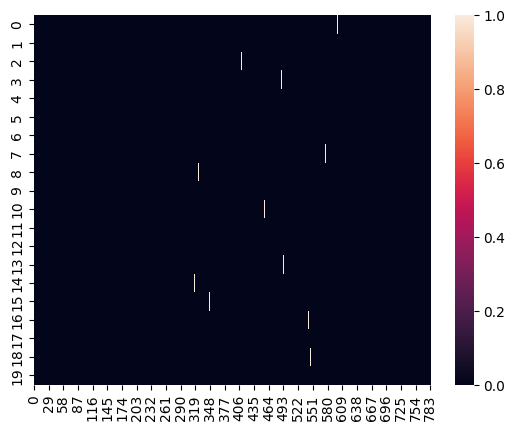

In [22]:
# selected features (discrete - test mode)
import seaborn as sns
sns.heatmap(np.array(discrete_logits))

In [ ]:
# --- Calculate test losses ---
model.eval()

if IS_SPARSE:
    test_output = model(X_test, train=False, X_mask=X_mask_test)
elif MISSING_DATA and DATA_IMPUTATION == 'mean':
    X_ = impute_mean(X_test, X_mask_test, masked_mean)
    test_output = model(X_, train=False, X_mask=None)
else:
    test_output = model(X_test, train=False, X_mask=None)

loss_multiplier = 1 / torch.numel(X_test)
complete_test_loss = eval_criterion(test_output, X_test) * loss_multiplier
print('---------------------------------------------------------')
print(f'Complete test loss for tryout {i}: {complete_test_loss}')

if MISSING_DATA:
    loss_multiplier = 1 / torch.sum(X_mask_test)
    sparse_test_loss = eval_criterion(test_output * X_mask_test, X_test * X_mask_test) * loss_multiplier
    print(f'Sparse test loss for tryout {i}: {sparse_test_loss}')

# --- Save model ---
# tag = f'{DECODER_TYPE}{"_missing" if MISSING_DATA else ""}{"" if DATA_IMPUTATION is None else "_"+DATA_IMPUTATION}{"_adj" if BATCH_ADJUST else ""}_k{k}b{BATCH_SIZE}e{num_epochs}{SUFFIX}'

# if not os.path.exists(f'./data/saved_models/{DATASET}'):
#     os.makedirs(f'./data/saved_models/{DATASET}')

# torch.save({
#     'tryout_num': i+1,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }, f'./data/saved_models/{DATASET}/{tag}.pt')

# --- Check redundancy in selected features ---
selected_features = model.get_indices()
if selected_features.shape != torch.unique(selected_features).shape:
    print('Oops, model selected same feature more than once!')

# --- Generate figures ---
# if DATASET == 'mnist':
#     idx = np.random.randint(0, len(testset), 10)
#     image_masks = X_mask_test[idx] if MISSING_DATA else None
#     create_mnist_figures(model, X_test[idx], image_masks=image_masks, folder=f'./data/figures/{DATASET}',
#                          tag=f'_{tag}')

# plot_performance(losses, folder=f'./data/figures/{DATASET}', tag=f'_{tag}')

# plot_annealing_schedule(annealing_schedule, folder=f'./data/figures/{DATASET}', tag=f'_{tag}')

# --- Check if num_epochs need to be increased ---
# if model.get_mean_max() >= MEAN_MAX_TARGET:
#     print(f'mean_max_target reached during tryout {i}, exiting training loop')
#     break

# num_epochs *= 2

# tag = f'{DECODER_TYPE}{"_missing" if MISSING_DATA else ""}{"" if DATA_IMPUTATION is None else "_"+DATA_IMPUTATION}_k{k}b{BATCH_SIZE}e{num_epochs}'
# model = load_model(f'./data/saved_models/{DATASET}/{tag}.pt', 28*28, k, decoder_type=DECODER_TYPE)
